![Two data scientists working on a dashboard.](hr-image-small.png)

A common problem when creating models to generate business value from data is that the datasets can be so large that it can take days for the model to generate predictions. Ensuring that your dataset is stored as efficiently as possible is crucial for allowing these models to run on a more reasonable timescale without having to reduce the size of the dataset.

You've been hired by a major online data science training provider called *Training Data Ltd.* to clean up one of their largest customer datasets. This dataset will eventually be used to predict whether their students are looking for a new job or not, information that they will then use to direct them to prospective recruiters.

You've been given access to `customer_train.csv`, which is a subset of their entire customer dataset, so you can create a proof-of-concept of a much more efficient storage solution. The dataset contains anonymized student information, and whether they were looking for a new job or not during training:

| Column                   | Description                                                                      |
|------------------------- |--------------------------------------------------------------------------------- |
| `student_id`             | A unique ID for each student.                                                    |
| `city`                   | A code for the city the student lives in.                                        |
| `city_development_index` | A scaled development index for the city.                                         |
| `gender`                 | The student's gender.                                                            |
| `relevant_experience`    | An indicator of the student's work relevant experience.                          |
| `enrolled_university`    | The type of university course enrolled in (if any).                              |
| `education_level`        | The student's education level.                                                   |
| `major_discipline`       | The educational discipline of the student.                                       |
| `experience`             | The student's total work experience (in years).                                  |
| `company_size`           | The number of employees at the student's current employer.                       |
| `company_type`           | The type of company employing the student.                                       |
| `last_new_job`           | The number of years between the student's current and previous jobs.             |
| `training_hours`         | The number of hours of training completed.                                       |
| `job_change`             | An indicator of whether the student is looking for a new job (`1`) or not (`0`). |

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load the dataset
ds_jobs = pd.read_csv("customer_train.csv")

# View the dataset
ds_jobs.head()

,student_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,job_change
0,8949,city_103,0.920,Male,Has relevant experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevant experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevant experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevant experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevant experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [70]:
# Create a copy of ds_jobs for transforming
ds_jobs_transformed = ds_jobs.copy()

# Start coding here. Use as many cells as you like!

### Functions

In [79]:
def remove_list_nans(lst:list):
    return ', '.join(['' if val is np.nan else str(val) for val in lst])

def get_unique_vals(df:pd.DataFrame, category_threshold:int=10):
    return [remove_list_nans(list(df[col].unique())) if df[col].nunique() <= category_threshold else [] for col in df.columns]

def dtype_details(df:pd.DataFrame, category_threshold:int=10, specific:str=None) -> pd.DataFrame:
    max_col_len = len( max( list(df.columns), key=len) )+1
    max_num_len = len( str( max( list(df.nunique()) ) ) )
    df_return = pd.DataFrame(df.dtypes, columns=['dtype'])
    df_return['unique'] = list(df.nunique())
    unique_vals = get_unique_vals(df, category_threshold=10)
    df_return['unique_values'] = unique_vals
    if specific:
        return df_return[df_return['dtype']==specific]
    else:
        return df_return

def change_type(df:pd.DataFrame, from_type:str, to_type:str) -> pd.core.dtypes:
    df_details = dtype_details(ds_jobs_transformed, 10)
    cols = df_details[df_details['dtype']==from_type].index.values
    ret= cols
    for col in cols:
        df[col] = ds_jobs_transformed[col].astype(np.int32)
    return df[ret].dtypes

def change_to_category(df:pd.DataFrame, cols: list, map_val:dict=None, category_list:list=None, order:bool=None, nan_replacer:str='None') -> None:
    for col in cols:
        df[col] = df[col].astype('category')
        if map_val:
            df[col] = df[col].cat.rename_categories(map_val)
        if category_list:
            df[col] = df[col].cat.set_categories(new_categories = category_list)
            df.loc[df[col].isna(), col] = nan_replacer
        if order:
            df[col] = df[col].cat.reorder_categories(new_categories = category_list, ordered=order)
            df.loc[df[col].isna(), col] = nan_replacer

In [86]:
ds_jobs_transformed['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [81]:
change_to_category(ds_jobs_transformed, ['gender'], category_list=['Male', 'Female', 'Other'], order=False, nan_replacer='Other')

In [82]:
ds_jobs_transformed['gender'].unique()

['Male', 'Other', 'Female']
Categories (3, object): ['Male', 'Female', 'Other']

In [ ]:
df_details = dtype_details(ds_jobs_transformed, 10)
df_details

### Columns containing categories with only two factors must be stored as Booleans (bool).

In [63]:
# Columns containing categories with only two factors must be stored as Booleans (bool).
dtype_details(ds_jobs_transformed)[dtype_details(ds_jobs_transformed)['unique']<=2]

,dtype,unique,unique_values
relevant_experience,category,2,"Has relevant experience, No relevant experience"
job_change,float64,2,"1.0, 0.0"


In [62]:
ds_jobs_transformed['relevant_experience'] = ds_jobs_transformed['relevant_experience'].astype('category')

In [67]:
category_list=[True, False]
map_value = {
    'Has relevant experience':True
    , 'No relevant experience':False
}
ds_jobs_transformed['relevant_experience'] = ds_jobs_transformed['relevant_experience'].cat.rename_categories(map_value)
# ds_jobs_transformed['relevant_experience'] = ds_jobs_transformed['relevant_experience'].cat.set_categories(new_categories = category_list)

In [72]:
map_value = {
    'Has relevant experience':True
    , 'No relevant experience':False
}
change_to_category(ds_jobs_transformed, ['relevant_experience'], map_value)
map_value = {
    1.0:True
    , 0.0:False
}
change_to_category(ds_jobs_transformed, ['job_change'], map_value)

In [68]:
ds_jobs_transformed['relevant_experience'].value_counts()

relevant_experience
True     13792
False     5366
Name: count, dtype: int64

In [ ]:
map_value = {
    1.0:True
    , 0.0:False
}
change_to_category(ds_jobs_transformed, ['job_change'], map_value)

In [ ]:
ds_jobs_transformed.dtypes

### Columns containing integers only must be stored as 32-bit integers (int32).

In [ ]:
dtype_details(ds_jobs_transformed, specific='int64')

In [ ]:
change_type(ds_jobs_transformed, 'int64', 'int32')

### Columns containing floats must be stored as 16-bit floats (float16).

In [75]:
ds_jobs_transformed['city_development_index'].astype('float16')

0        0.919922
1        0.775879
2        0.624023
3        0.789062
4        0.767090
           ...   
19153    0.877930
19154    0.919922
19155    0.919922
19156    0.801758
19157    0.854980
Name: city_development_index, Length: 19158, dtype: float16

In [73]:
dtype_details(ds_jobs_transformed, specific='float64')

,dtype,unique,unique_values
city_development_index,float64,93,[]


In [ ]:
change_type(ds_jobs_transformed, 'float64', 'float16')

In [ ]:
ds_jobs_transformed.dtypes

### Columns containing nominal categorical data must be stored as the category data type.

In [ ]:
dtype_details(ds_jobs_transformed)

In [ ]:
dtype_details(ds_jobs_transformed)[(dtype_details(ds_jobs_transformed)['unique']<=10)&(dtype_details(ds_jobs_transformed)['dtype']!='category')]

In [ ]:
cols = dtype_details(ds_jobs_transformed)[(dtype_details(ds_jobs_transformed)['unique']<=10)&(dtype_details(ds_jobs_transformed)['dtype']!='category')].index.values
change_to_category(ds_jobs_transformed, cols)

In [ ]:
dtype_details(ds_jobs_transformed)[(dtype_details(ds_jobs_transformed)['unique']<=10)&(dtype_details(ds_jobs_transformed)['dtype']!='category')]

In [ ]:
ds_jobs_transformed.dtypes

### Columns containing ordinal categorical data must be stored as ordered categories, and not mapped to numerical values, with an order that reflects the natural order of the column.

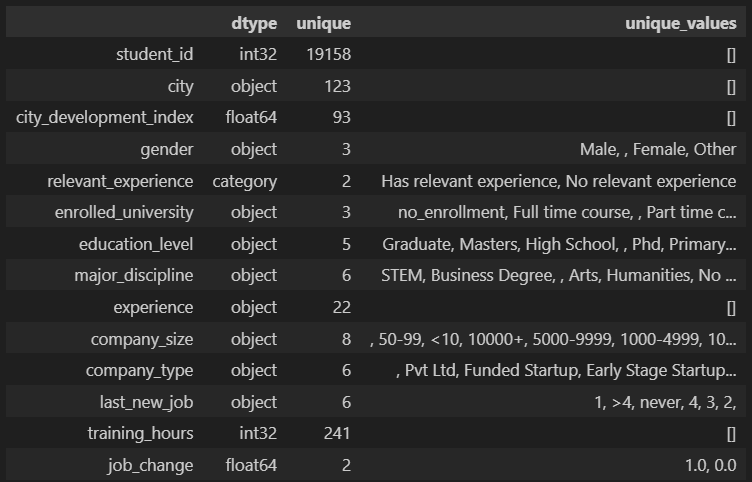

In [ ]:
ds_jobs_transformed['gender'].unique()

In [ ]:
ds_jobs_transformed.loc[ds_jobs_transformed['gender'].isna(), 'gender'] = 'Other'

In [ ]:
ds_jobs_transformed['gender'].unique()

In [ ]:
ds_jobs_transformed['enrolled_university'].unique()

In [ ]:
ds_jobs_transformed.loc[ds_jobs_transformed['enrolled_university'].isna(), 'enrolled_university'] = 'no_enrollment'
ds_jobs_transformed['enrolled_university'].unique()

In [ ]:
ds_jobs_transformed['education_level'].unique()

In [ ]:
ds_jobs_transformed['education_level'] = ds_jobs_transformed['education_level'].cat.set_categories(new_categories = ['None', 'Primary School', 'High School', 'Graduate', 'Masters', 'Phd'], ordered=True)
ds_jobs_transformed.loc[ds_jobs_transformed['education_level'].isna(), 'education_level'] = 'None'
ds_jobs_transformed['education_level'].unique()

In [ ]:
ds_jobs_transformed['major_discipline'].unique()

In [ ]:
ds_jobs_transformed['major_discipline'] = ds_jobs_transformed['major_discipline'].cat.set_categories(
    new_categories = ['STEM', 'Business Degree', 'None', 'Arts', 'Humanities', 'No Major', 'Other']
    , ordered=False
)
ds_jobs_transformed.loc[ds_jobs_transformed['major_discipline'].isna(), 'major_discipline'] = 'None'
ds_jobs_transformed['major_discipline'].unique()

In [ ]:
ds_jobs_transformed['company_size'].unique()

In [ ]:
ds_jobs_transformed['company_size'] = ds_jobs_transformed['company_size'].cat.set_categories(
    new_categories = ['None', '<10', '10-49', '50-99', '100-499', '500-999', '1000-4999', '5000-9999', '10000+']
    , ordered=True
)
ds_jobs_transformed.loc[ds_jobs_transformed['company_size'].isna(), 'company_size'] = 'None'
ds_jobs_transformed['company_size'].unique()

In [ ]:
ds_jobs_transformed['company_type'].unique()

In [ ]:
ds_jobs_transformed['company_type'] = ds_jobs_transformed['company_type'].cat.set_categories(
    new_categories = ['None', 'Pvt Ltd', 'Funded Startup', 'Early Stage Startup', 'Other', 'Public Sector', 'NGO']
    , ordered=False
)
ds_jobs_transformed.loc[ds_jobs_transformed['company_type'].isna(), 'company_type'] = 'None'
ds_jobs_transformed['company_type'].unique()

In [88]:
ds_jobs_transformed['last_new_job'].dtype

dtype('O')

In [91]:
ds_jobs_transformed['last_new_job'] = ds_jobs_transformed['last_new_job'].astype('category')
ds_jobs_transformed['last_new_job'] = ds_jobs_transformed['last_new_job'].cat.set_categories(
    new_categories = ['never', '1', '2', '3', '4','>4']
    , ordered=True
)
ds_jobs_transformed.loc[ds_jobs_transformed['last_new_job'].isna(), 'last_new_job'] = 'never'
ds_jobs_transformed['last_new_job'].unique()

['1', '>4', 'never', '4', '3', '2']
Categories (6, object): ['never' < '1' < '2' < '3' < '4' < '>4']

In [94]:
ds_jobs_transformed['last_new_job'].cat.categories

Index(['never', '1', '2', '3', '4', '>4'], dtype='object')

In [ ]:
ds_jobs_transformed['experience'].unique()

In [ ]:
ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].astype('category')
ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].cat.set_categories(
    new_categories = ['None', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
    , ordered=True
)
ds_jobs_transformed.loc[ds_jobs_transformed['experience'].isna(), 'experience'] = 'None'
ds_jobs_transformed['experience'].unique()

### The DataFrame should be filtered to only contain students with 10 or more years of experience at companies with at least 1000 employees, as their recruiter base is suited to more experienced professionals at enterprise companies.

In [ ]:
ds_jobs_transformed.head()

In [ ]:
ds_jobs_transformed['experience'].unique()

In [ ]:
ds_jobs_transformed = ds_jobs_transformed[ds_jobs_transformed['experience']>='10']
ds_jobs_transformed['experience'].unique()

In [ ]:
ds_jobs_transformed['experience'].value_counts()

In [17]:
def change_to_category(df: pd.DataFrame, cols: list, map_val:dict=None, category_list:list=None, order:bool=None, nan_replacer:str='None'):
    for col in cols:
        df[col] = df[col].astype('category')
        if map_val:
            df[col] = df[col].cat.rename_categories(map_val)
        if categories:
            df[col] = df[col].cat.set_categories(new_categories = category_list)
            df.loc[df[col].isna(), col] = nan_replacer
        if order:
            df[col] = df[col].cat.reorder_categories(new_categories = category_list, ordered=order)
            df.loc[df[col].isna(), col] = nan_replacer

In [24]:
type(ds_jobs_transformed['experience'].dtype)

pandas.core.dtypes.dtypes.CategoricalDtype

In [19]:
# ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].astype('category')
# ds_jobs_transformed['experience'] = ds_jobs_transformed['experience'].cat.set_categories(
#     new_categories = ['None', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
#     , ordered=True
# )
# ds_jobs_transformed.loc[ds_jobs_transformed['experience'].isna(), 'experience'] = 'None'
ds_jobs_transformed['experience'].unique()

['>20', '15', '5', '<1', '11', ..., '6', '9', '8', '20', 'None']
Length: 23
Categories (23, object): ['None' < '<1' < '1' < '2' ... '18' < '19' < '20' < '>20']

In [20]:
categories = ['None', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
change_to_category(ds_jobs_transformed, ['experience'], category_list=categories, order=True)
ds_jobs_transformed['experience'].unique()

['>20', '15', '5', '<1', '11', ..., '6', '9', '8', '20', 'None']
Length: 23
Categories (23, object): ['None' < '<1' < '1' < '2' ... '18' < '19' < '20' < '>20']

In [23]:
ds_jobs_transformed['experience'].value_counts(dropna=False)

experience
>20     3286
5       1430
4       1403
3       1354
6       1216
2       1127
7       1028
10       985
9        980
8        802
15       686
11       664
14       586
1        549
<1       522
16       508
12       494
13       399
17       342
19       304
18       280
20       148
None      65
Name: count, dtype: int64